Versi 6 ini adalah revisi bimbingan dengan Bpk. Naufal

1. v6 adalah gallery akan diubah menjadi data face_aligned (porF) yang ada di folder trio_cam, dari yang sebelumnya campuran dari folder "portraits" dan karena kurangnya subjek di folder tersebut maka digabungkan dengan gambar wajah yang ada di folder "trio_cam"
2. v6.1 adalah versi inferensi tanpa tuning GFPGan

Kenapa kita ga usah hitung hipotenusa nya karena logika nya, kegagalan pada arcface adalah tidak dapat mendeteksi wajah, dimana hal ini berkaitan pada kondisi penangkapan citra yang tidak dapat melihat wajah subjek dengan jelas (hanya terlihat rambut dan sedikit dahi). Jadi klasifikasi nilai tinggi dan jarak harus dipisah. Kalau pake hipotenusa kita seolah mengabaikan dampak dari ketinggian yang berpengaruh pada model rekognisi


# Pipeline Rekognisi Wajah v6.1

1.  **Jalur A (Baseline):** Pengenalan wajah langsung pada citra asli (probe).
2.  **Jalur B (Dengan Peningkatan):** Pengenalan wajah pada citra setelah melalui proses restorasi kualitas menggunakan GFPGAN.


##### Impor Pustaka & Konfigurasi Path


In [78]:
import os
import sys
import glob
import cv2
import numpy as np
import json
import time
import pickle
import torch
from collections import defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from deepface import DeepFace
from gfpgan import GFPGANer
import pyiqa
from scipy.spatial.distance import cosine
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# --- Konfigurasi Path --- 
BASE_DIR = os.path.abspath('.')
PROJECT_ROOT = os.path.abspath(os.path.join(BASE_DIR, '..')) # Asumsi notebook ada di dalam subfolder proyek
GALLERY_PATH = os.path.join(BASE_DIR, 'data', 'gallery6.1')
PROBES_PATH = os.path.join(BASE_DIR, 'data', 'probes')
RESULTS_PATH = os.path.join(BASE_DIR, 'results_v6.1')
CACHE_PATH = os.path.join(BASE_DIR, 'cache_v6.1')

# --- Konfigurasi Path untuk Output Gambar ---
CROPPED_FACES_PATH = os.path.join(RESULTS_PATH, 'cropped_faces')
RESTORED_FACES_PATH = os.path.join(RESULTS_PATH, 'restored_faces')
RESTORED_IMGS_PATH = os.path.join(RESULTS_PATH, 'restored_imgs')
COMPARISON_PATH = os.path.join(RESULTS_PATH, 'cmp')

# --- Path File Cache ---
EMBEDDING_CACHE_FILE = os.path.join(CACHE_PATH, 'embedding_cache.pkl')

# Pastikan semua direktori output ada, jika tidak maka buat direktori baru.
for path in [RESULTS_PATH, CACHE_PATH, CROPPED_FACES_PATH, RESTORED_FACES_PATH, RESTORED_IMGS_PATH, COMPARISON_PATH]:
    os.makedirs(path, exist_ok=True)

print(f"Notebook berjalan di direktori: {BASE_DIR}")
print(f"Hasil akan disimpan di: {RESULTS_PATH}")

Notebook berjalan di direktori: d:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\pipeline_skripsi
Hasil akan disimpan di: d:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\pipeline_skripsi\results_v6.1


##### Inisialisasi Model-Model Utama

Tahap ini memuat semua model yang diperlukan ke dalam memori (CPU atau GPU). Ini termasuk:

- **GFPGAN**: Untuk restorasi wajah.
- **pyiqa (BRISQUE & NIQE)**: Untuk penilaian kualitas gambar.
- **DeepFace (ArcFace)**: Untuk ekstraksi fitur (embedding) wajah. Dilakukan _warm-up_ agar pemrosesan pertama tidak lambat.


In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Menggunakan device: {DEVICE}')

print("Memuat model GFPGAN v1.4...")
gfpgan_model_path = os.path.join(PROJECT_ROOT, 'model_gfpgan', 'gfpgan', 'weights', 'GFPGANv1.4.pth')
if not os.path.exists(gfpgan_model_path):
    print(f"ERROR: Model GFPGAN tidak ditemukan di {gfpgan_model_path}")

else:
    gfpgan_restorer = GFPGANer(
        model_path=gfpgan_model_path,
        upscale=2, 
        arch='clean',
        channel_multiplier=2,
        bg_upsampler=None,
        device=DEVICE
        
    )
    print("Model GFPGAN siap.")

# Inisialisasi IQA Assessors dari pyiqa
print("Memuat model BRISQUE (No-Reference IQA)...")
brisque_assessor = pyiqa.create_metric('brisque', device=DEVICE)
print("Model BRISQUE siap.")

print("Memuat model NIQE (No-Reference IQA)...")
niqe_assessor = pyiqa.create_metric('niqe', device=DEVICE)
print("Model NIQE siap.")

# Pre-load model DeepFace untuk 'warming up' agar inferensi pertama tidak lambat
print("Warm-up model DeepFace (ArcFace)...")
try:
    _ = DeepFace.represent(np.zeros((112, 112, 3), dtype=np.uint8), model_name='ArcFace', enforce_detection=False)
    print("Model DeepFace siap.")
except Exception as e:
    print(f"Gagal melakukan warm-up DeepFace: {e}")

Menggunakan device: cuda
Memuat model GFPGAN v1.4...
Model GFPGAN siap.
Memuat model BRISQUE (No-Reference IQA)...
Model BRISQUE siap.
Memuat model NIQE (No-Reference IQA)...
Model NIQE siap.
Warm-up model DeepFace (ArcFace)...
Model DeepFace siap.


### Langkah 4: Fungsi-Fungsi Utilitas


In [3]:
def parse_filename(filename: str) -> dict | None:
    """
    Mengekstrak metadata dari nama file probe sesuai format yang ditentukan.
    Format: 'subject_X_height_Y_distance_Z.JPG'
    
    Args:
        filename (str): Path atau nama file gambar.
    
    Returns:
        dict: Dictionary berisi metadata jika parsing berhasil, atau None jika gagal.
    """
    try:
        base_name = os.path.basename(filename)
        parts = os.path.splitext(base_name)[0].split('_')
        if len(parts) < 5: return None

        subject_id, height_id, distance_id = parts[0], parts[2], parts[4]
        if height_id == 'na' or distance_id == 'na': return None

        distance_val = int(distance_id)
        distance_m = 17 - (distance_val / 2)

        height_m = 0
        if height_id == "0":
            height_m = 1.5
        else:
            height_m = height_id

        return {
            'subject_id': subject_id,
            'distance_m': distance_m,
            'height_id': height_id,
            'height_m': height_m,
        }
    except (IndexError, ValueError):
        # Gagal parsing karena format nama file salah atau nilai tidak valid
        return None

def get_embedding(image_path_or_array, model_name='ArcFace', detector_backend='retinaface') -> list | None:
    """
    Menghasilkan vektor embedding wajah dari sebuah gambar.

    Args:
        image_path_or_array: Path file gambar atau array numpy BGR.
        model_name (str): Model yang digunakan untuk rekognisi.
        detector_backend (str): Model yang digunakan untuk deteksi wajah.

    Returns:
        list: Vektor embedding jika wajah terdeteksi, atau None jika tidak.
    """
    try:
        embedding_objs = DeepFace.represent(
            img_path=image_path_or_array,
            model_name=model_name,
            enforce_detection=True, # Memastikan wajah terdeteksi
            detector_backend=detector_backend
        )
        # Ambil embedding dari wajah pertama yang terdeteksi
        return embedding_objs[0]['embedding']
    except (ValueError, AttributeError, IndexError, TypeError):
        # ValueError sering muncul jika DeepFace tidak menemukan wajah
        return None

def find_best_match(probe_embedding: list, gallery_embeddings: dict) -> tuple[str | None, float]:
    """
    Mencari subjek di galeri yang paling cocok dengan embedding probe.

    Args:
        probe_embedding (list): Vektor embedding dari gambar probe.
        gallery_embeddings (dict): Dictionary {subject_id: embedding} dari galeri.

    Returns:
        tuple: (subject_id terbaik, jarak kosinus minimum).
    """
    if probe_embedding is None or not gallery_embeddings:
        return None, float('inf')
    
    best_match_id = None
    min_dist = float('inf')
    
    for subject_id, gallery_embedding in gallery_embeddings.items():
        if gallery_embedding is None: continue
        dist = cosine(probe_embedding, gallery_embedding)
        if dist < min_dist:
            min_dist = dist
            best_match_id = subject_id
            
    return best_match_id, min_dist

def get_iqa_score(image_array, assessor):
    # Cek jika image_array valid (tidak None dan tidak kosong)
    if image_array is None or image_array.size == 0:
        return None
    try:
        # Konversi BGR (OpenCV) ke RGB, lalu ke Tensor [0,1] C,H,W
        img_rgb = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
        img_tensor = torch.from_numpy(img_rgb).permute(2, 0, 1).unsqueeze(0) / 255.0
        score = assessor(img_tensor.to(DEVICE)).item()
        return score
    except Exception as e:
        return None

print("Fungsi utilitas siap digunakan.")

Fungsi utilitas siap digunakan.


### Langkah 5: Pembuatan Galeri Referensi

Proses ini mengekstrak fitur (embedding) dari setiap gambar di folder galeri. Hasilnya disimpan dalam sebuah dictionary `gallery_embeddings`, yang akan menjadi database referensi untuk pencocokan.


In [4]:
gallery_embeddings = {}
gallery_files = glob.glob(os.path.join(GALLERY_PATH, '*.jpg'))

if not gallery_files:
    print(f"PERINGATAN: Tidak ada gambar ditemukan di folder galeri: {GALLERY_PATH}")
else:
    print(f"Membuat database fitur dari {len(gallery_files)} gambar di galeri...")
    for g_file in tqdm(gallery_files, desc="Membangun Galeri"):
        subject_id = os.path.basename(g_file).split('_')[0]
        embedding = get_embedding(g_file)
        if embedding is not None:
            gallery_embeddings[subject_id] = embedding
        else:
            print(f"Gagal membuat embedding untuk file galeri: {g_file}")

    print(f"Database fitur galeri berhasil dibuat untuk {len(gallery_embeddings)} subjek: {list(gallery_embeddings.keys())}")

Membuat database fitur dari 11 gambar di galeri...


Membangun Galeri:   0%|          | 0/11 [00:00<?, ?it/s]

Database fitur galeri berhasil dibuat untuk 11 subjek: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k']


### Langkah 6: Eksekusi Pipeline Utama

Ini adalah inti dari notebook. Setiap gambar _probe_ akan diproses melalui dua jalur (A dan B). Semua hasil, termasuk prediksi, status keberhasilan, dan skor kualitas gambar, akan disimpan dalam list `results_v6` dan kemudian diekspor ke file JSON.


In [5]:
# Muat cache embedding jika ada untuk mempercepat proses
try:
    with open(EMBEDDING_CACHE_FILE, 'rb') as f:
        embedding_cache = pickle.load(f)
    print(f"Berhasil memuat {len(embedding_cache)} embedding dari cache.")
except (FileNotFoundError, EOFError):
    embedding_cache = {}
    print("Cache embedding tidak ditemukan atau korup, akan membuat baru.")

probe_files = glob.glob(os.path.join(PROBES_PATH, '*.JPG'))
results_v6 = []

print(f"Memulai pemrosesan {len(probe_files)} citra uji...")
start_time = time.time()

for probe_path in tqdm(probe_files, desc="Memproses Probe"):
    metadata = parse_filename(probe_path)
    if not metadata:
        print(f"Skipping file dengan format nama salah: {os.path.basename(probe_path)}")
        continue
    else:
        print(metadata)

    probe_filename = os.path.basename(probe_path)
    ground_truth = metadata['subject_id']
    
    # --- Inisialisasi hasil untuk iterasi ini ---
    prediction_A, prediction_B = None, None
    is_correct_A, is_correct_B = False, False
    restoration_succeeded = False
    brisque_original, brisque_restored = None, None
    niqe_original, niqe_restored = None, None

    # --- Jalur A (Tanpa Restorasi) ---
    if probe_filename in embedding_cache:
        embedding_A = embedding_cache[probe_filename]
    else:
        embedding_A = get_embedding(probe_path)
        embedding_cache[probe_filename] = embedding_A
    
    if embedding_A is not None:
        prediction_A, _ = find_best_match(embedding_A, gallery_embeddings)
        if prediction_A == ground_truth:
            is_correct_A = True

    # --- Jalur B (Dengan Restorasi & Penyimpanan Gambar) ---
    try:
        img_original = cv2.imread(probe_path, cv2.IMREAD_COLOR)
        if img_original is None:
            print(f"Gagal membaca gambar: {probe_filename}")
            continue

        # Hitung IQA pada gambar asli (keseluruhan)
        brisque_original = get_iqa_score(img_original, brisque_assessor)
        niqe_original = get_iqa_score(img_original, niqe_assessor)
        
        # Lakukan restorasi dengan GFPGAN
        cropped_faces, restored_faces, restored_pasted_img = gfpgan_restorer.enhance(
            img_original, has_aligned=True, only_center_face=False)
        
        if restored_faces and restored_faces[0] is not None:
            original_cropped_face = cropped_faces[0]
            restored_face = restored_faces[0]
            restoration_succeeded = True

            # --- Menyimpan semua jenis gambar output ---
            cv2.imwrite(os.path.join(CROPPED_FACES_PATH, probe_filename), original_cropped_face)
            cv2.imwrite(os.path.join(RESTORED_FACES_PATH, probe_filename), restored_face)
            if restored_pasted_img is not None:
                cv2.imwrite(os.path.join(RESTORED_IMGS_PATH, probe_filename), restored_pasted_img)
            
            # --- Membuat dan menyimpan gambar komparasi ---
            try:
                h, w, _ = restored_face.shape
                # Resize wajah asli agar ukurannya sama dengan wajah restorasi untuk perbandingan
                upscaled_original = cv2.resize(original_cropped_face, (w, h), interpolation=cv2.INTER_CUBIC)
                comparison_image = np.concatenate((upscaled_original, restored_face), axis=1)
                cv2.imwrite(os.path.join(COMPARISON_PATH, probe_filename), comparison_image)
            except Exception as cmp_e:
                print(f"Gagal membuat gambar perbandingan untuk {probe_filename}: {cmp_e}")

            # --- Melanjutkan ke evaluasi pada wajah yang direstorasi ---
            brisque_restored = get_iqa_score(restored_face,brisque_assessor)
            niqe_restored = get_iqa_score(restored_face, niqe_assessor)
            
            embedding_B = get_embedding(restored_face)
            if embedding_B is not None:
                prediction_B, _ = find_best_match(embedding_B, gallery_embeddings)
                if prediction_B == ground_truth:
                    is_correct_B = True
    except Exception as e:
        print(f"Error saat memproses Jalur B untuk {probe_filename}: {e}")
        # Set nilai default jika terjadi error pada Jalur B
        is_correct_B = False
        restoration_succeeded = False

    results_v6.append({
        'file': probe_filename,
        'metadata': metadata,
        'ground_truth': ground_truth,
        'prediction_A': prediction_A,
        'is_correct_A': is_correct_A,
        'prediction_B': prediction_B,
        'is_correct_B': is_correct_B,
        'restoration_succeeded': restoration_succeeded,
        'brisque_original_img': brisque_original,
        'brisque_restored_face': brisque_restored,
        'niqe_original_img': niqe_original,
        'niqe_restored_face': niqe_restored
    })

# --- Simpan Hasil dan Cache ---
end_time = time.time()
print(f"\nSelesai memproses {len(results_v6)} citra uji dalam {end_time - start_time:.2f} detik.")

results_file_path = os.path.join(RESULTS_PATH, 'pipeline_results_v6.json')
with open(results_file_path, 'w') as f:
    json.dump(results_v6, f, indent=4)
print(f"Variabel 'results_v6' berhasil disimpan ke: {results_file_path}")

with open(EMBEDDING_CACHE_FILE, 'wb') as f:
    pickle.dump(embedding_cache, f)
print(f"Cache embedding berhasil disimpan ke: {EMBEDDING_CACHE_FILE}")

Cache embedding tidak ditemukan atau korup, akan membuat baru.
Memulai pemrosesan 1364 citra uji...


Memproses Probe:   0%|          | 0/1364 [00:00<?, ?it/s]

{'subject_id': 'a', 'distance_m': 17.0, 'height_id': '0', 'height_m': 1.5}
{'subject_id': 'a', 'distance_m': 16.5, 'height_id': '0', 'height_m': 1.5}
{'subject_id': 'a', 'distance_m': 16.0, 'height_id': '0', 'height_m': 1.5}
{'subject_id': 'a', 'distance_m': 15.5, 'height_id': '0', 'height_m': 1.5}
{'subject_id': 'a', 'distance_m': 15.0, 'height_id': '0', 'height_m': 1.5}
{'subject_id': 'a', 'distance_m': 14.5, 'height_id': '0', 'height_m': 1.5}
{'subject_id': 'a', 'distance_m': 14.0, 'height_id': '0', 'height_m': 1.5}
{'subject_id': 'a', 'distance_m': 13.5, 'height_id': '0', 'height_m': 1.5}
{'subject_id': 'a', 'distance_m': 13.0, 'height_id': '0', 'height_m': 1.5}
{'subject_id': 'a', 'distance_m': 12.5, 'height_id': '0', 'height_m': 1.5}
{'subject_id': 'a', 'distance_m': 12.0, 'height_id': '0', 'height_m': 1.5}
{'subject_id': 'a', 'distance_m': 11.5, 'height_id': '0', 'height_m': 1.5}
{'subject_id': 'a', 'distance_m': 11.0, 'height_id': '0', 'height_m': 1.5}
{'subject_id': 'a', 'dist

### Langkah 7: Analisis Hasil dan Visualisasi

Bagian ini memuat kembali hasil yang baru saja disimpan dalam format JSON ke dalam Pandas DataFrame untuk analisis yang lebih mudah. Metrik evaluasi akan dihitung dan berbagai visualisasi akan dibuat untuk mempermudah interpretasi hasil.


In [79]:
# Muat hasil dari file JSON untuk analisis
results_file_path = os.path.join(RESULTS_PATH, 'pipeline_results_v6.json')
try:
    with open(results_file_path, 'r') as f:
        results_data = json.load(f)
except FileNotFoundError:
    print(f"File hasil tidak ditemukan: {results_file_path}. Jalankan Langkah 6 terlebih dahulu.")
    # Hentikan eksekusi sel ini jika file tidak ada
    df = pd.DataFrame()
else:
    df = pd.DataFrame(results_data)
    # Konversi kolom 'metadata' yang berisi dictionary menjadi beberapa kolom terpisah
    df_meta = pd.json_normalize(df['metadata'])
    df = pd.concat([df.drop('metadata', axis=1), df_meta], axis=1)

if not df.empty:
    print(f"Data hasil berhasil dimuat. Total {len(df)} baris.")
    display(df.head())
else:
    print("DataFrame kosong, analisis tidak dapat dilanjutkan.")

Data hasil berhasil dimuat. Total 1364 baris.


,file,ground_truth,prediction_A,is_correct_A,prediction_B,is_correct_B,restoration_succeeded,brisque_original_img,brisque_restored_face,niqe_original_img,niqe_restored_face,subject_id,distance_m,height_id,height_m
0,a_gp_0_ef_00.jpg,a,b,False,a,True,True,51.662781,8.611023,NaN,5.621739,a,17.0,0,1.5
1,a_gp_0_ef_01.jpg,a,b,False,d,False,True,37.802917,15.667175,NaN,6.071807,a,16.5,0,1.5
2,a_gp_0_ef_02.jpg,a,b,False,d,False,True,45.284363,16.542664,NaN,6.592134,a,16.0,0,1.5
3,a_gp_0_ef_03.jpg,a,b,False,d,False,True,37.946960,11.513367,NaN,6.200671,a,15.5,0,1.5
4,a_gp_0_ef_04.jpg,a,b,False,c,False,True,31.923523,8.702820,NaN,5.870449,a,15.0,0,1.5


#### 7.1 Analisis Performa Keseluruhan


In [127]:
import pandas as pd
import numpy as np
import os

def create_performance_pivot(df: pd.DataFrame, interval: float = 2.0) -> pd.DataFrame:
    """
    Membuat pivot table (matriks) yang merangkum performa berdasarkan
    tinggi aktual dan interval jarak dengan format yang lebih baik.

    Args:
        df (pd.DataFrame): DataFrame hasil eksperimen.
        interval (float): Lebar interval untuk pengelompokan jarak (dalam meter).

    Returns:
        pd.DataFrame: Pivot table performa dengan multi-level columns.
    """
    df_analysis = df.copy()

    # 1. Persiapan Data: Konversi tipe data dan buat grup jarak
    df_analysis['distance_m'] = pd.to_numeric(df_analysis['distance_m'], errors='coerce')
    df_analysis['height_m'] = pd.to_numeric(df_analysis['height_m'], errors='coerce')
    df_analysis.dropna(subset=['distance_m', 'height_m'], inplace=True)

    if df_analysis.empty:
        print("INFO: Tidak ada data yang valid untuk dianalisis.")
        return pd.DataFrame()

    max_dist = df_analysis['distance_m'].max()
    distance_bins = np.arange(0, max_dist + interval, interval)
    # Membuat kolom kategori untuk interval jarak
    df_analysis['distance_group'] = pd.cut(df_analysis['distance_m'], bins=distance_bins, right=False)
    
    # 2. Agregasi Data
    # Kelompokkan data berdasarkan tinggi dan grup jarak untuk menghitung metrik
    agg_df = df_analysis.groupby(['height_m', 'distance_group'], observed=True).agg(
        Sampel=('file', 'size'),
        Akurasi_A=('is_correct_A', 'mean'),
        Akurasi_B=('is_correct_B', 'mean')
    ).reset_index()

    # 3. Hitung Peningkatan Akurasi
    # Menggunakan np.divide untuk menangani pembagian dengan nol secara aman
    peningkatan = np.divide(
        (agg_df['Akurasi_B'] - agg_df['Akurasi_A']),
        agg_df['Akurasi_A'],
        out=np.full_like(agg_df['Akurasi_A'], np.nan), # Default jika pembagi nol
        where=agg_df['Akurasi_A'] != 0
    )
    # Kasus spesial: jika Akurasi A adalah 0 dan B > 0, peningkatannya tak terhingga
    peningkatan[(agg_df['Akurasi_A'] == 0) & (agg_df['Akurasi_B'] > 0)] = np.inf
    agg_df['Peningkatan'] = peningkatan
    
    # 4. Buat Pivot Table dari data yang sudah diagregasi
    pivot_table = agg_df.pivot(
        index='height_m',
        columns='distance_group',
        values=['Sampel', 'Akurasi_A', 'Akurasi_B', 'Peningkatan']
    )
    
    if pivot_table.empty:
        return pivot_table

    # 5. Tata Ulang Kolom agar lebih mudah dibaca
    # Tukar level kolom agar grup jarak menjadi level teratas
    pivot_table = pivot_table.swaplevel(0, 1, axis=1).sort_index(axis=1)
    
    # Ubah nama kolom agar lebih rapi
    pivot_table.columns.names = ['Interval Jarak', 'Metrik']
    
    return pivot_table

# --- CARA MENJALANKAN ---
# Asumsikan 'df' adalah DataFrame Anda yang sudah dimuat

# Misalkan df sudah ada
# df = pd.read_json('path_to_your_data.json')
# df = pd.json_normalize(df.to_dict('records'))
# df.columns = df.columns.str.replace('metadata.', '', regex=False)

def format_peningkatan(val):
    """Fungsi kustom untuk memformat kolom Peningkatan."""
    if pd.isna(val):
        return "N/A"
    if np.isinf(val):
        return "∞"
    return f"{val:+.1%}"

if 'df' in locals() and not df.empty:
    # Buat matriks performa
    performance_matrix = create_performance_pivot(df, interval=2.0)
    
    print("--- Matriks Performa ---")
    if not performance_matrix.empty:
        # Gunakan Styler untuk format tampilan yang lebih baik
        styled_matrix = performance_matrix.style.format({
            'Sampel': '{:.0f}',
            'Akurasi_A': '{:.1%}',
            'Akurasi_B': '{:.1%}',
            'Peningkatan': format_peningkatan # Gunakan fungsi kustom
        }, na_rep="N/A").background_gradient(
            cmap='RdYlGn', subset=pd.IndexSlice[:, pd.IndexSlice[:, 'Peningkatan']], axis=None
        )
        display(styled_matrix)
    else:
        print("Tidak ada matriks yang bisa ditampilkan.")
else:
    print("❌ DataFrame 'df' tidak ditemukan atau kosong.")

print("Cara baca interval jarak -> dari 2m sampai kurang dari 4m (3.5m)")



--- Matriks Performa ---


Cara baca interval jarak -> dari 2m sampai kurang dari 4m (3.5m)


#### 7.2 Confusion Matrix

Confusion matrix membantu kita melihat secara detail bagaimana model mengklasifikasikan setiap subjek. Kita bisa melihat subjek mana yang sering salah diklasifikasikan dan tertukar dengan subjek lain.



Memulai proses pembuatan confusion matrix...
✅ Confusion Matrix untuk tinggi 1.5m disimpan di: ./results_v6.1/hasil_berdasarkan_tinggi\cm_restorasi_tinggi_1_5m.png


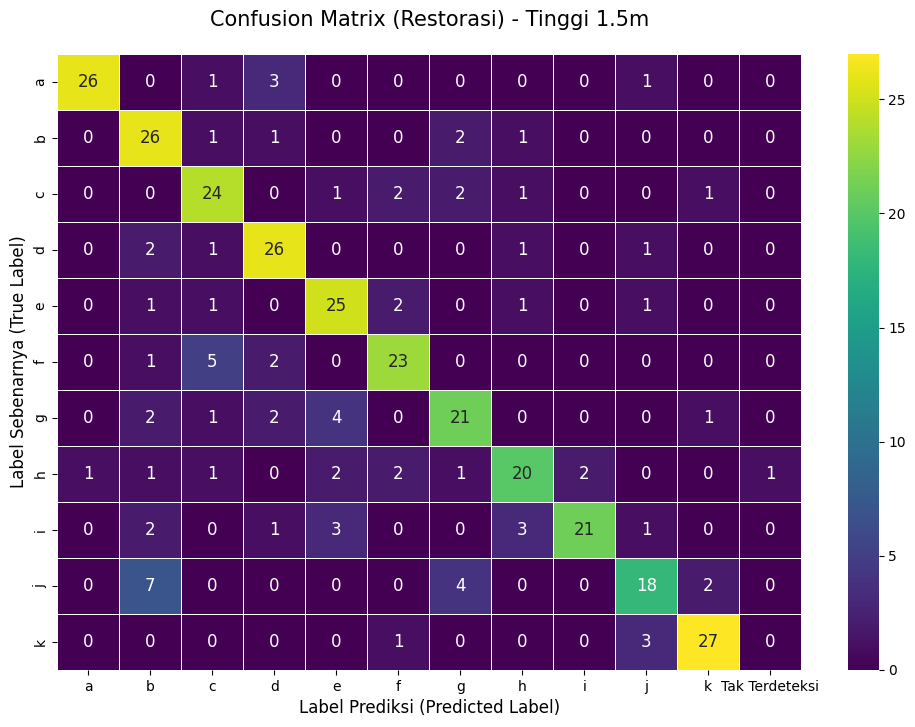

✅ Confusion Matrix untuk tinggi 3m disimpan di: ./results_v6.1/hasil_berdasarkan_tinggi\cm_restorasi_tinggi_3m.png


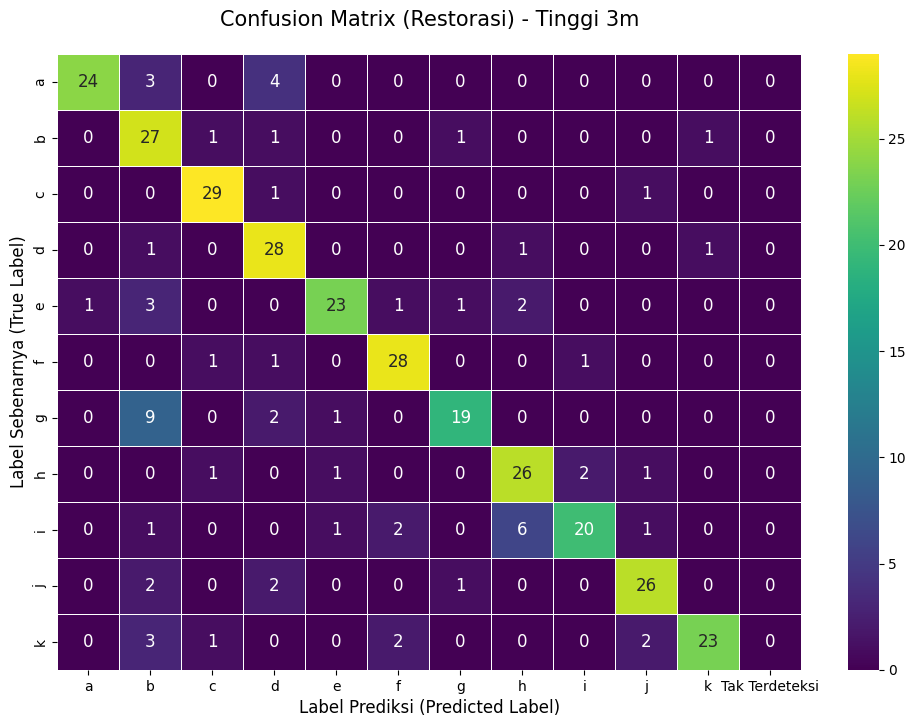

✅ Confusion Matrix untuk tinggi 4m disimpan di: ./results_v6.1/hasil_berdasarkan_tinggi\cm_restorasi_tinggi_4m.png


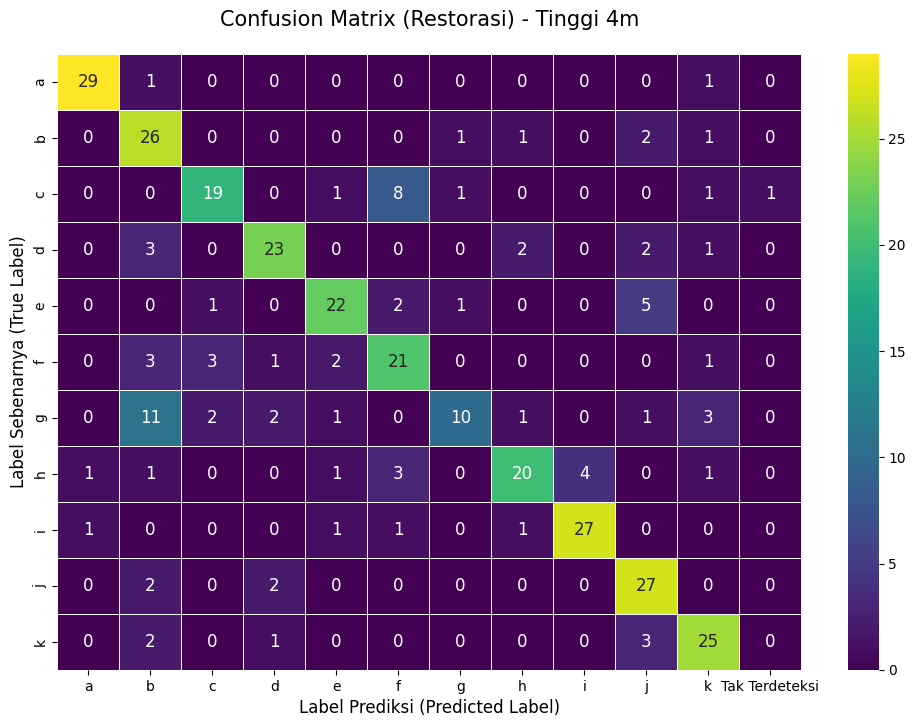

✅ Confusion Matrix untuk tinggi 5m disimpan di: ./results_v6.1/hasil_berdasarkan_tinggi\cm_restorasi_tinggi_5m.png


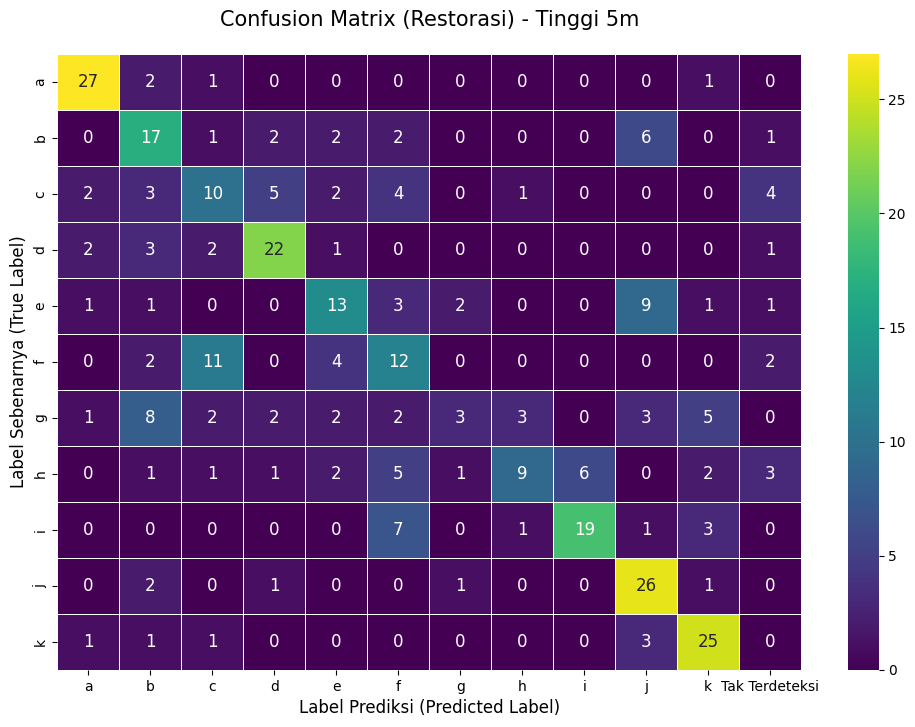

In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os
import json

df.head()

def plot_restoration_cm_by_height(df: pd.DataFrame, height: float, labels: list, results_path: str):
    """
    Membuat, menampilkan, dan menyimpan confusion matrix untuk jalur restorasi (B)
    berdasarkan tinggi tertentu, TERMASUK kolom untuk prediksi yang gagal.
    """
    df_filtered = df[df['height_m'] == height].copy()

    if df_filtered.empty:
        print(f"INFO: Tidak ada data ditemukan untuk tinggi {height}m. Plot dilewati.")
        return

    pred_col = 'prediction_B'
    
    failures = df_filtered[df_filtered[pred_col].isna() & df_filtered['ground_truth'].notna()]
    failure_counts_by_gt = failures['ground_truth'].value_counts()

    cm_df = df_filtered.dropna(subset=['ground_truth', pred_col])
    
    if cm_df.empty:
        print(f"INFO: Tidak ada prediksi yang berhasil pada tinggi {height}m, hanya menampilkan kegagalan.")
        return

    y_true = cm_df['ground_truth']
    y_pred = cm_df[pred_col]
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plot_labels = labels + ["Tak Terdeteksi"]
    
    cm_new = np.zeros((len(labels), len(plot_labels)), dtype=int)
    
    cm_new[:, :-1] = cm
    
    for i, label in enumerate(labels):
        cm_new[i, -1] = failure_counts_by_gt.get(label, 0)
        
    title = f'Confusion Matrix (Restorasi) - Tinggi {height}m'
    
    plt.figure(figsize=(12, 8)) # Lebarkan sedikit figure untuk kolom tambahan
    sns.heatmap(cm_new, annot=True, fmt='d', cmap='viridis',
                xticklabels=plot_labels, yticklabels=labels, linewidths=.5, annot_kws={"size": 12})
    plt.title(title, fontsize=15, pad=20)
    plt.ylabel('Label Sebenarnya (True Label)', fontsize=12)
    plt.xlabel('Label Prediksi (Predicted Label)', fontsize=12)
    
    if not os.path.exists(results_path):
        os.makedirs(results_path)

    height_str = str(height).replace('.', '_')
    file_path = os.path.join(results_path, f'cm_restorasi_tinggi_{height_str}m.png')
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    print(f"✅ Confusion Matrix untuk tinggi {height}m disimpan di: {file_path}")
    plt.show()

RESULTS_TINGGI_PATH = './results_v6.1/hasil_berdasarkan_tinggi'

if not df.empty and 'height_m' in df.columns:
    heights_to_plot = [1.5, "3", "4", "5"]
    all_labels = pd.concat([df['ground_truth'], df.get('prediction_A', pd.Series()), df.get('prediction_B', pd.Series())]).dropna().unique()
    unique_labels = sorted(all_labels)

    if not unique_labels:
        print("❌ Tidak ada label unik yang ditemukan dalam data.")
    else:
        print("\nMemulai proses pembuatan confusion matrix...")
        for height in heights_to_plot:
            plot_restoration_cm_by_height(df, height, unique_labels, RESULTS_TINGGI_PATH)
else:
    print("\n❌ DataFrame kosong atau tidak memiliki kolom 'height_m' yang diperlukan.")

##### 7.2.1 Confusion Matrix - Akurasi


✅ Total Keseluruhan Prediksi: 1364
✅ Performance Heatmap (interval 2.0m) disimpan di: ./results_v6.1/hasil_dengan_interval\performance_heatmap_2.0m_interval.png


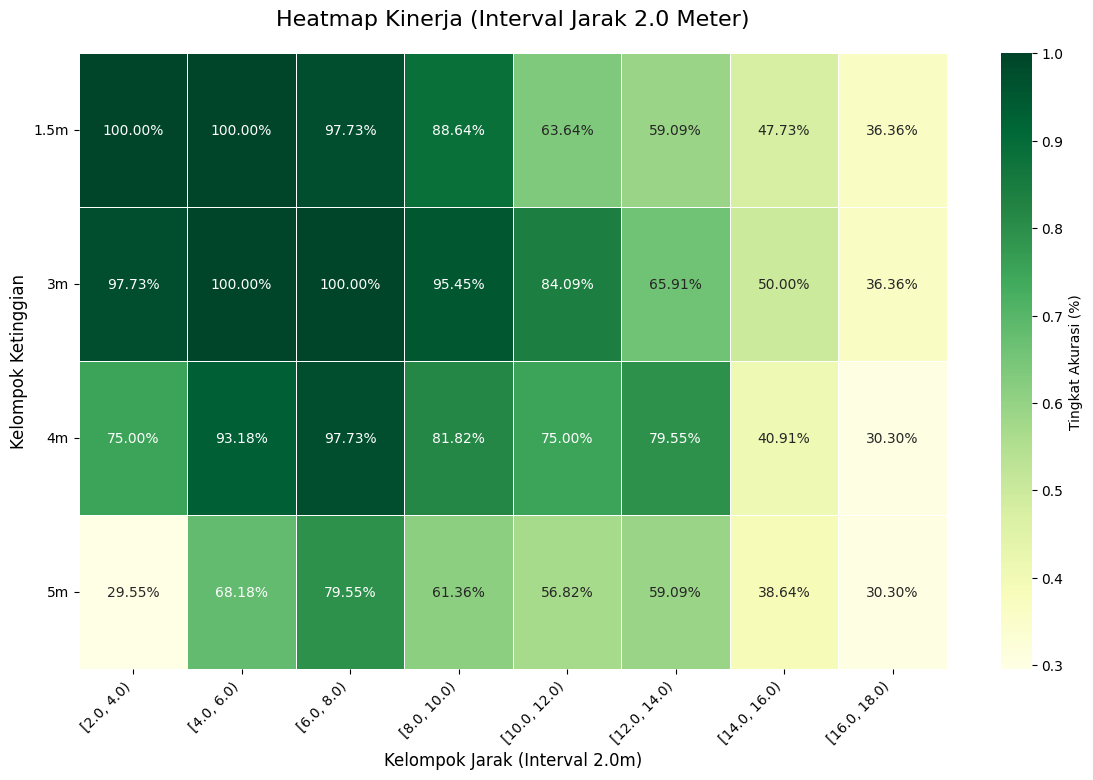

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_performance_heatmap_interval(df: pd.DataFrame, results_path: str, interval: float = 2.0):
    """
    Membuat heatmap kinerja (akurasi) dengan interval jarak yang bisa diatur.
    """
    df_plot = df.copy()

    df_plot['distance_m'] = pd.to_numeric(df_plot['distance_m'], errors='coerce')
    df_plot['height_m'] = pd.to_numeric(df_plot['height_m'], errors='coerce')
    df_plot.dropna(subset=['distance_m', 'height_m', 'is_correct_B'], inplace=True)

    if df_plot.empty:
        print("INFO: Tidak ada data valid setelah dibersihkan.")
        return
    
    max_dist = df_plot['distance_m'].max()
    distance_bins = np.arange(0, max_dist + interval, interval)

    height_bins = [0, 2, 3.5, 4.5, 5.5]
    height_labels = ["1.5m", "3m", "4m", "5m"]
    

    try:
        df_plot['distance_group'] = pd.cut(df_plot['distance_m'], bins=distance_bins, right=False)
        df_plot['height_group'] = pd.cut(df_plot['height_m'], bins=height_bins, labels=height_labels, right=False)
    except ValueError as e:
        print(f"❌ Error saat membuat grup: {e}.")
        return

    try:
        performance_matrix = df_plot.pivot_table(
            index='height_group',
            columns='distance_group',
            values='is_correct_B',
            aggfunc='mean'
        )
    except Exception as e:
        print(f"❌ Gagal membuat pivot table. Error: {e}")
        return

    if performance_matrix.empty:
        print("INFO: Tidak ada data yang cukup untuk membuat performance heatmap.")
        return

    # Plotting heatmap
    plt.figure(figsize=(14, 8))
    sns.heatmap(
        performance_matrix,
        annot=True,
        fmt='.2%',
        cmap='YlGn',
        linewidths=.5,
        cbar_kws={'label': 'Tingkat Akurasi (%)'}
    )
    plt.title(f'Heatmap Kinerja (Interval Jarak {interval} Meter)', fontsize=16, pad=20)
    plt.ylabel('Kelompok Ketinggian', fontsize=12)
    plt.xlabel(f'Kelompok Jarak (Interval {interval}m)', fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)

    # Simpan file
    if not os.path.exists(results_path):
        os.makedirs(results_path)
    file_path = os.path.join(results_path, f'performance_heatmap_{interval}m_interval.png')
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    print(f"✅ Performance Heatmap (interval {interval}m) disimpan di: {file_path}")
    plt.show()


RESULTS_PATH = './results_v6.1/hasil_dengan_interval'

if not df.empty:
    plot_performance_heatmap_interval(df, RESULTS_PATH, interval=2.0)
else:
    print("❌ DataFrame kosong.")


##### 7.2.1 Confusion Matrix - Prediksi Benar


✅ Total Keseluruhan Prediksi Benar: 962
✅ Heatmap Jumlah Prediksi Benar (Tinggi Aktual) disimpan di: ./results_v6.1/hasil_tinggi_aktual\correct_count_actual_height_2.0m_interval.png


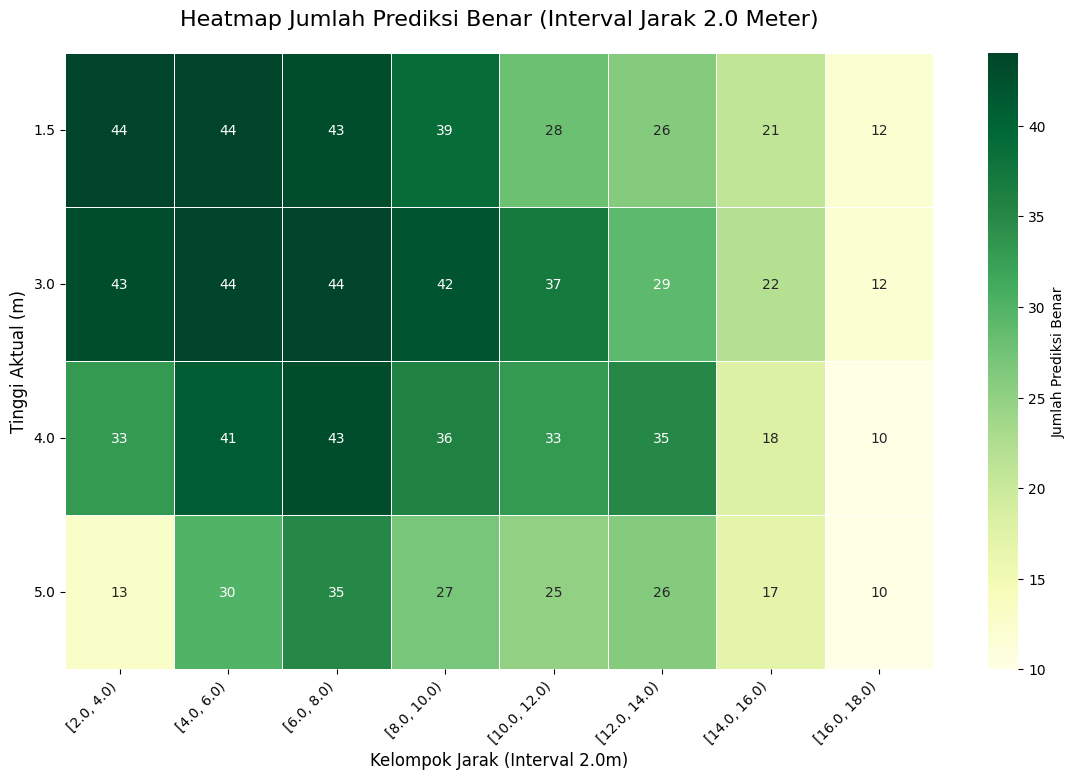

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_correct_count_heatmap(df: pd.DataFrame, results_path: str, interval: float = 2.0):
    df_plot = df.copy()

    # Pastikan tipe data numerik dan tidak ada nilai kosong
    df_plot['distance_m'] = pd.to_numeric(df_plot['distance_m'], errors='coerce')
    df_plot['height_m'] = pd.to_numeric(df_plot['height_m'], errors='coerce')
    df_plot.dropna(subset=['distance_m', 'height_m', 'is_correct_B'], inplace=True)

    if df_plot.empty:
        print("INFO: Tidak ada data valid setelah dibersihkan.")
        return

    max_dist = df_plot['distance_m'].max()
    distance_bins = np.arange(2, max_dist + interval, interval)
    
    try:
        df_plot['distance_group'] = pd.cut(df_plot['distance_m'], bins=distance_bins, right=False)
    except ValueError as e:
        print(f"❌ Error saat membuat grup jarak: {e}.")
        return

    try:
        performance_matrix = df_plot.pivot_table(
            index='height_m',      
            columns='distance_group', 
            values='is_correct_B',
            aggfunc='sum'
        )
    except Exception as e:
        print(f"❌ Gagal membuat pivot table. Error: {e}")
        return
        
    if performance_matrix.empty:
        print("INFO: Tidak ada data yang cukup untuk membuat heatmap.")
        return

    total_kebenaran = performance_matrix.sum().sum()
    print(f"✅ Total Keseluruhan Prediksi Benar: {int(total_kebenaran)}")

    # Plotting heatmap
    plt.figure(figsize=(14, 8))
    sns.heatmap(
        performance_matrix,
        annot=True,
        fmt='g',
        cmap='YlGn',
        linewidths=.5,
        cbar_kws={'label': 'Jumlah Prediksi Benar'}
    )
    plt.title(f'Heatmap Jumlah Prediksi Benar (Interval Jarak {interval} Meter)', fontsize=16, pad=20)
    plt.ylabel('Tinggi Aktual (m)', fontsize=12) # <-- Label diubah
    plt.xlabel(f'Kelompok Jarak (Interval {interval}m)', fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)

    if not os.path.exists(results_path):
        os.makedirs(results_path)
    file_path = os.path.join(results_path, f'correct_count_actual_height_{interval}m_interval.png')
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    print(f"✅ Heatmap Jumlah Prediksi Benar (Tinggi Aktual) disimpan di: {file_path}")
    plt.show()

RESULTS_PATH = './results_v6.1/hasil_tinggi_aktual'

if not df.empty:
    plot_correct_count_heatmap(df, RESULTS_PATH, interval=2.0)
else:
    print("❌ DataFrame kosong.")

##### 7.2.1 Confusion Matrix - Prediksi Salah


✅ Total Keseluruhan Prediksi Salah: 388
✅ Heatmap Jumlah Prediksi Salah disimpan di: ./results_v6.1/hasil_prediksi_salah\incorrect_count_heatmap_2.0m_interval.png


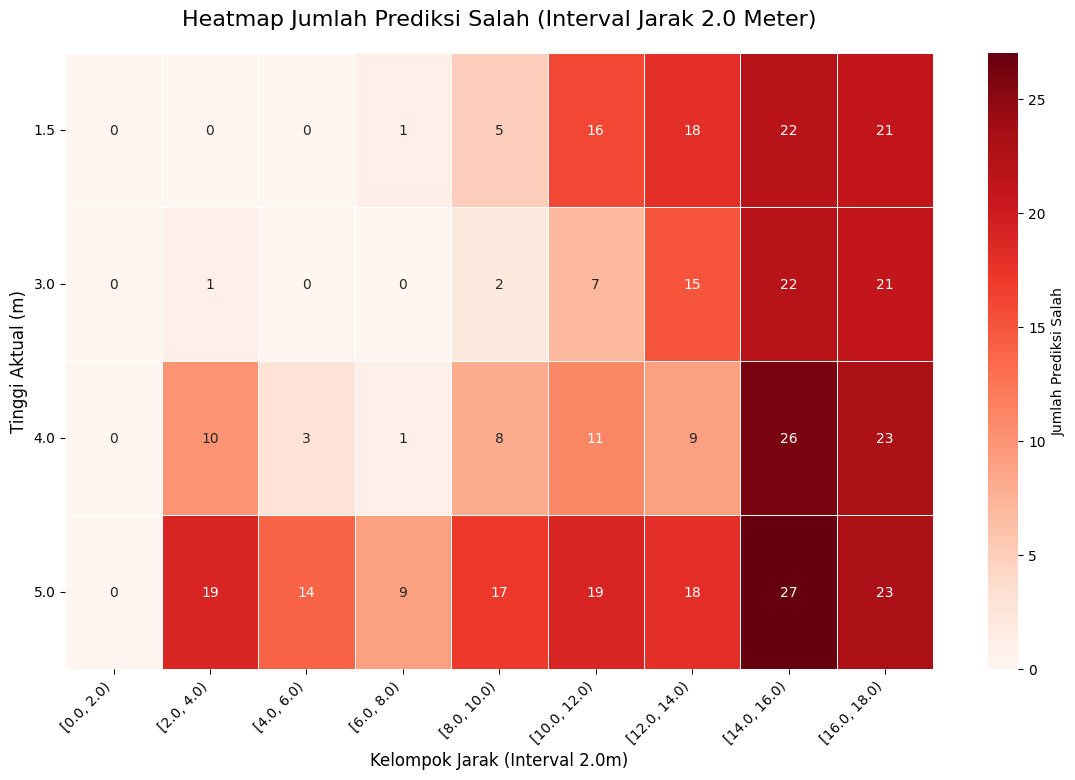

In [114]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_incorrect_count_heatmap(df: pd.DataFrame, results_path: str, interval: float = 2.0):
    """
    Membuat heatmap yang menunjukkan JUMLAH PREDIKSI SALAH
    berdasarkan tinggi aktual dan interval jarak.
    """
    df_plot = df.copy()

    # Pastikan tipe data numerik
    df_plot['distance_m'] = pd.to_numeric(df_plot['distance_m'], errors='coerce')
    df_plot['height_m'] = pd.to_numeric(df_plot['height_m'], errors='coerce')
    
    # --- PERUBAHAN EKSPLISIT DI SINI ---
    # Hapus baris jika kolom-kolom kunci ini memiliki nilai null/NaN.
    # Secara eksplisit memeriksa 'prediction_B' sesuai permintaan Anda.
    df_plot.dropna(subset=['distance_m', 'height_m', 'prediction_B'], inplace=True)
    df_plot.dropna(subset=['distance_m', 'height_m', 'is_correct_B'], inplace=True)
    # --- AKHIR PERUBAHAN ---

    if df_plot.empty:
        print("INFO: Tidak ada data valid setelah dibersihkan.")
        return

    # Buat kolom baru 'is_incorrect'
    df_plot['is_incorrect'] = (df_plot['is_correct_B'] == False).astype(int)

    # Binning untuk Jarak
    max_dist = df_plot['distance_m'].max()
    distance_bins = np.arange(0, max_dist + interval, interval)
    
    try:
        df_plot['distance_group'] = pd.cut(df_plot['distance_m'], bins=distance_bins, right=False)
    except ValueError as e:
        print(f"❌ Error saat membuat grup jarak: {e}.")
        return

    # Pivot Table menggunakan kolom 'is_incorrect'
    try:
        incorrect_matrix = df_plot.pivot_table(
            index='height_m',
            columns='distance_group',
            values='is_incorrect',
            aggfunc='sum'
        )
    except Exception as e:
        print(f"❌ Gagal membuat pivot table. Error: {e}")
        return
        
    if incorrect_matrix.empty:
        print("INFO: Tidak ada data yang cukup untuk membuat heatmap prediksi salah.")
        return

    total_kesalahan = incorrect_matrix.sum().sum()
    print(f"✅ Total Keseluruhan Prediksi Salah: {int(total_kesalahan)}")

    # (Sisa kode plotting tetap sama...)
    plt.figure(figsize=(14, 8))
    sns.heatmap(
        incorrect_matrix,
        annot=True,
        fmt='g',
        cmap='Reds',
        linewidths=.5,
        cbar_kws={'label': 'Jumlah Prediksi Salah'}
    )
    plt.title(f'Heatmap Jumlah Prediksi Salah (Interval Jarak {interval} Meter)', fontsize=16, pad=20)
    plt.ylabel('Tinggi Aktual (m)', fontsize=12)
    plt.xlabel(f'Kelompok Jarak (Interval {interval}m)', fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)

    if not os.path.exists(results_path):
        os.makedirs(results_path)
    file_path = os.path.join(results_path, f'incorrect_count_heatmap_{interval}m_interval.png')
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    print(f"✅ Heatmap Jumlah Prediksi Salah disimpan di: {file_path}")
    plt.show()

# --- CARA MENJALANKAN ---
RESULTS_PATH_SALAH = './results_v6.1/hasil_prediksi_salah'

if not df.empty:
    plot_incorrect_count_heatmap(df, RESULTS_PATH_SALAH, interval=2.0)
else:
    print("❌ DataFrame kosong.")

##### 7.2.1 Confusion Matrix - Prediksi Gagal


✅ Total Keseluruhan Prediksi Gagal: 14
✅ Heatmap Jumlah Gagal Prediksi disimpan di: ./results_v6.1/hasil_gagal_prediksi\failure_count_heatmap_2.0m_interval.png


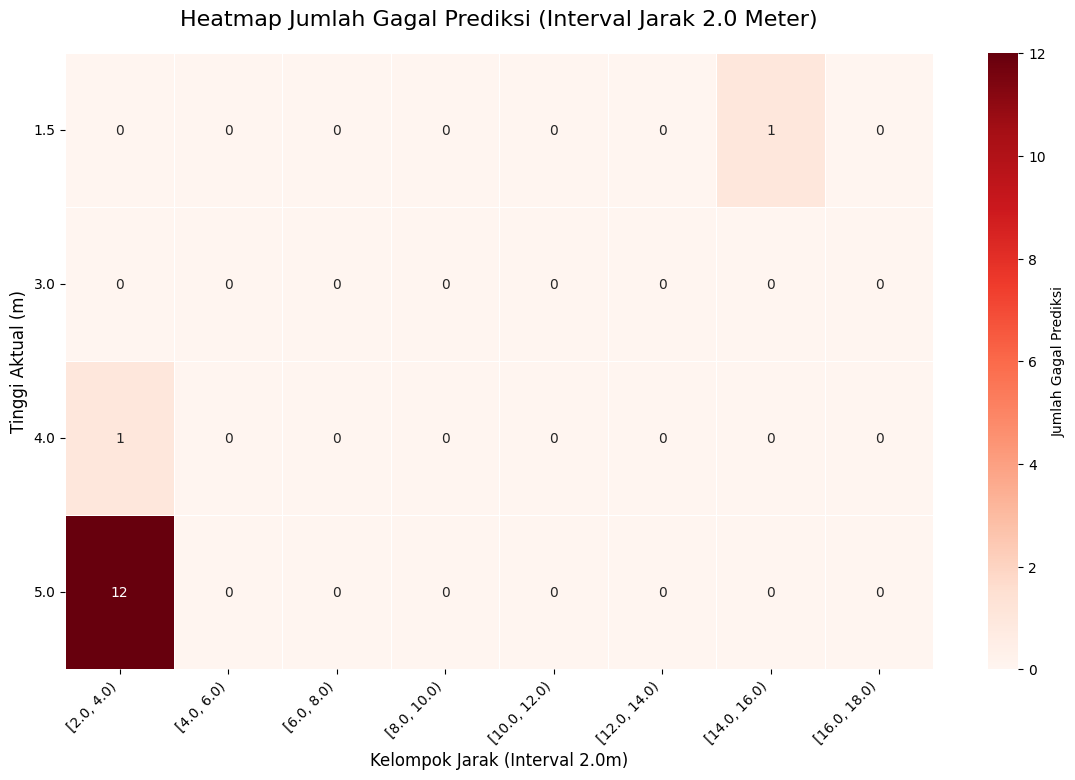

In [116]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_failure_count_heatmap(df: pd.DataFrame, results_path: str, interval: float = 2.0):
    """
    Membuat heatmap yang menunjukkan JUMLAH PREDIKSI GAGAL (NaN)
    berdasarkan tinggi aktual dan interval jarak.
    """
    df_plot = df.copy()

    # Pastikan tipe data numerik
    df_plot['distance_m'] = pd.to_numeric(df_plot['distance_m'], errors='coerce')
    df_plot['height_m'] = pd.to_numeric(df_plot['height_m'], errors='coerce')
    # Di sini kita hanya dropna untuk kolom kondisi, bukan kolom prediksi
    df_plot.dropna(subset=['distance_m', 'height_m'], inplace=True)

    if df_plot.empty:
        print("INFO: Tidak ada data valid setelah dibersihkan.")
        return

    # --- PERUBAHAN UTAMA DI SINI ---

    # 1. Buat kolom baru 'is_failure'
    # .isna() menghasilkan True jika prediksi NaN, .astype(int) mengubah True->1, False->0
    df_plot['is_failure'] = df_plot['prediction_B'].isna().astype(int)

    # 2. Binning untuk Jarak (tetap sama)
    max_dist = df_plot['distance_m'].max()
    distance_bins = np.arange(2, max_dist + interval, interval)
    
    try:
        df_plot['distance_group'] = pd.cut(df_plot['distance_m'], bins=distance_bins, right=False)
    except ValueError as e:
        print(f"❌ Error saat membuat grup jarak: {e}.")
        return

    # 3. Pivot Table menggunakan kolom 'is_failure' yang baru
    try:
        failure_matrix = df_plot.pivot_table(
            index='height_m',
            columns='distance_group',
            values='is_failure', # <-- Gunakan kolom penanda kegagalan
            aggfunc='sum'
        )
    except Exception as e:
        print(f"❌ Gagal membuat pivot table. Error: {e}")
        return
        
    # --- AKHIR PERUBAHAN ---

    if failure_matrix.empty:
        print("INFO: Tidak ada data yang cukup untuk membuat heatmap kegagalan.")
        return

    total_kegagalan = failure_matrix.sum().sum()
    print(f"✅ Total Keseluruhan Prediksi Gagal: {int(total_kegagalan)}")

    # Plotting heatmap
    plt.figure(figsize=(14, 8))
    sns.heatmap(
        failure_matrix,
        annot=True,
        fmt='g',
        cmap='Reds', # <-- Skema warna diubah menjadi merah untuk indikasi 'buruk'
        linewidths=.5,
        cbar_kws={'label': 'Jumlah Gagal Prediksi'} # <-- Label color bar diubah
    )
    plt.title(f'Heatmap Jumlah Gagal Prediksi (Interval Jarak {interval} Meter)', fontsize=16, pad=20)
    plt.ylabel('Tinggi Aktual (m)', fontsize=12)
    plt.xlabel(f'Kelompok Jarak (Interval {interval}m)', fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)

    # Simpan file
    if not os.path.exists(results_path):
        os.makedirs(results_path)
    file_path = os.path.join(results_path, f'failure_count_heatmap_{interval}m_interval.png')
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    print(f"✅ Heatmap Jumlah Gagal Prediksi disimpan di: {file_path}")
    plt.show()


# --- CARA MENJALANKAN ---
# Anda bisa menjalankan ini setelah heatmap keberhasilan
RESULTS_PATH_GAGAL = './results_v6.1/hasil_gagal_prediksi'

if not df.empty:
    plot_failure_count_heatmap(df, RESULTS_PATH_GAGAL, interval=2.0)
else:
    print("❌ DataFrame kosong.")